# Trajectory Model Exploration
## Atus Data - Eating and Health

**v0.1.0**

In [2]:
# import early libraries
import numpy as np
import pandas as pd
import pandas_profiling

In [3]:
from IPython.display import display

# Set data path
atus_data_path = 'atus_aggregate_clean.csv'

# Read data in
atus_df = pd.read_csv(atus_data_path, index_col='case_id')

display(atus_df.shape, atus_df.head(10))

(69880, 29)

activity_list  assisted_meals   bmi  drink_diet_soda  \
case_id                                                                       
20060101060001                    20             NaN  25.0              NaN   
20060101060014                   NaN             NaN  36.0              NaN   
20060101060025                   6,6             NaN  26.2              NaN   
20060101060033           2,3,5,12,17             2.0  26.4              NaN   
20060101060038                   3,3             NaN  24.6              NaN   
20060101060049                   8,8             NaN  27.4              NaN   
20060101060057  3,8,9,16,18,19,21,21             4.0  33.3              NaN   
20060101060067                   NaN             NaN  22.6              NaN   
20060101060077                   8,9             NaN  27.6              NaN   
20060101060092                    13             2.0  30.7              NaN   

                drink_soda  eating_duration_24  exercise_frequency_last_week  \
case_id                                                                        
20060101060001         NaN                 NaN                           NaN   
20060101060014         NaN                 NaN                           NaN   
20060101060025         NaN                 NaN                           NaN   
20060101060033         NaN                 NaN                           NaN   
20060101060038         NaN                 NaN                           NaN   
20060101060049         NaN                 NaN                           NaN   
20060101060057         NaN                 NaN                           NaN   
20060101060067         NaN                 NaN                           NaN   
20060101060077         NaN                 NaN                           NaN   
20060101060092         NaN                 NaN                           NaN   

                fast_food_frequency_last_week  fast_food_yesterday  \
case_id                                                              
20060101060001                            NaN                  NaN   
20060101060014                            NaN                  NaN   
20060101060025                            NaN                  NaN   
20060101060033                            NaN                  NaN   
20060101060038                            NaN                  NaN   
20060101060049                            NaN                  NaN   
20060101060057                            NaN                  NaN   
20060101060067                            NaN                  NaN   
20060101060077                            NaN                  NaN   
20060101060092                            NaN                  NaN   

                general_health  ...  secondary_drinking_all_day  \
case_id                         ...                               
20060101060001             3.0  ...                         NaN   
20060101060014             1.0  ...                         NaN   
20060101060025             4.0  ...                         NaN   
20060101060033             3.0  ...                         NaN   
20060101060038             3.0  ...                         NaN   
20060101060049             3.0  ...                         NaN   
20060101060057             2.0  ...                         NaN   
20060101060067             5.0  ...                         NaN   
20060101060077             5.0  ...                         NaN   
20060101060092             2.0  ...                         NaN   

                secondary_drinking_day_prior  secondary_drinking_duration  \
case_id                                                                     
20060101060001                           0.0                          0.0   
20060101060014                           0.0                          0.0   
20060101060025                           1.0                        120.0   
20060101060033                           1.0                        143.0   
20060

In [3]:
# Profile Data

atus_df.profile_report()

## Choose Features & Targets
Selecting variables for targeting and taking care of leakage.

### Targets
* bmi: Body Mass Index
* general_health: General Health

### Features
**BMI is a function of height and weight.  They can be included in general_health models, but not in BMI**

**General Drop List**
* 'case_id', 'secondary_eating_duration', 'secondary_eating_duration', 'activity_list', 'income_130_pov', 'fast_food_yesterday', 'assisted_meals', 'secondary_eating_all_day', 'secondary_drinking_all_day'


In [4]:
# Drop general terms and split into target-specific dataframes

general_drop_list = ['case_id', 'secondary_eating_duration', 'secondary_eating_duration', 'activity_list', 'income_130_pov', 
                     'fast_food_yesterday', 'assisted_meals', 'secondary_eating_all_day', 'secondary_drinking_all_day']


df_bmi = atus_df.reset_index().drop(columns=general_drop_list+['weight_lb', 'height_in'])
df_bmi = df_bmi[df_bmi.bmi.notna()]

df_general_health = atus_df.reset_index().drop(columns=general_drop_list)
df_general_health = df_general_health[df_general_health.general_health.notna()]


## Building Imputers

**High Missing Value Features**

Goal: maintain distribution post impute if possible

**Methods:**

*Note: Version 1.X.X will use iterative imputer across the entire feature set for both targets
* low missing (<10%) use sklearn iterative imputer (version 2 and beyond)
* high missing (>=10%) model-based imputation via XXX  (version 2 and beyond)

**Considerations:**

* iterative imputer will give nonsense or in between values for certain columns.
* cast to int: ['num_children', 'meal_preparer', 'primary_eating_duration', 'secondary_drinking_duration', 'exercise_frequency_last_week', 'fast_food_frequency_last_week']
* cast to bool: ['drink_diet_soda',	'drink_soda', 'income_185_pov', 'prepare_meat_last_week', 'prepare_milk_last_week', 'secondary_eating_day_prior', 'snap_benefits']

In [5]:
# Build data preprocessing pipeline with sklearn column transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer

bmi_columns = df_bmi.columns.tolist()
gen_health_columns = df_general_health.columns.tolist()

it_imputer_gen_purpose = IterativeImputer(max_iter=10, random_state=42, imputation_order='descending',
                                         min_value=0, )

bmi_impute_transformer = ColumnTransformer(
    [
        ('it_imputer', it_imputer_gen_purpose, bmi_columns),
    ]
)

gen_health_impute_transformer = ColumnTransformer(
    [
        ('it_imputer', it_imputer_gen_purpose, gen_health_columns),
    ]
)

In [6]:
# Impute values for bmi and general_health sets
df_bmi_transformed = pd.DataFrame(bmi_impute_transformer.fit_transform(df_bmi), columns=bmi_columns)
df_general_health_transformed = pd.DataFrame(gen_health_impute_transformer.fit_transform(df_general_health), columns=gen_health_columns)

### Custom Transformers, Scalers, Casting

In [7]:
# Methods
def feature_in_df(feature, dataframe):
    return feature in dataframe.columns

**Cast columns to appropriate type, scale**

In [8]:
# integer casting leaning on pandas coercing data
cast_to_int =  ['num_children', 'meal_preparer', 'primary_eating_duration',
                'secondary_drinking_duration', 'exercise_frequency_last_week',
                'fast_food_frequency_last_week', 'year', 'secondary_drinking_day_prior', 
                'general_health', 'grocery_shopper', 'eating_duration_24', 
               ]

for feature in cast_to_int:
    if feature_in_df(feature, df_bmi_transformed):
        df_bmi_transformed[feature] = df_bmi_transformed[feature].astype(int)
        
    if feature_in_df(feature, df_general_health_transformed):
        df_general_health_transformed[feature] = df_general_health_transformed[feature].astype(int)


In [9]:
# boolean castsing via logistic function borrowed from nueral network squashing
import math

b=2.5
logistic_function = lambda x:( 1 / (1 + math.exp(-2*b*(x-0.5))) ) > 0.5

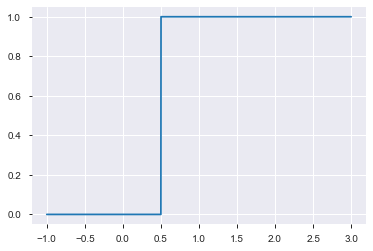

In [10]:
# review logistic function
import matplotlib.pyplot as plt

x = np.arange(-1,3,0.001)
y = np.array(list(map(logistic_function, x)))

plt.plot(x,y)

In [11]:
# Transform boolean values with logistic function

cast_to_bool = ['drink_diet_soda', 'drink_soda', 'income_185_pov', 'prepare_meat_last_week',
               'prepare_milk_last_week', 'secondary_eating_day_prior', 'snap_benefits']
    
for feature in cast_to_bool:
    if feature_in_df(feature, df_bmi_transformed):
        df_bmi_transformed[feature] = df_bmi_transformed[feature].apply(logistic_function)
        
    if feature_in_df(feature, df_general_health_transformed):
        df_general_health_transformed[feature] = df_general_health_transformed[feature].apply(logistic_function)

In [12]:
# Review transformation
from IPython.display import display

display(df_bmi_transformed.dtypes, df_bmi_transformed.isna().sum())

bmi                              float64
drink_diet_soda                     bool
drink_soda                          bool
eating_duration_24                 int32
exercise_frequency_last_week       int32
fast_food_frequency_last_week      int32
general_health                     int32
grocery_shopper                    int32
income_185_pov                      bool
meal_preparer                      int32
num_children                       int32
prepare_meat_last_week              bool
prepare_milk_last_week              bool
primary_eating_duration            int32
secondary_drinking_day_prior       int32
secondary_drinking_duration        int32
secondary_eating_day_prior          bool
snap_benefits                       bool
statistical_weight               float64
year                               int32
dtype: object

bmi                              0
drink_diet_soda                  0
drink_soda                       0
eating_duration_24               0
exercise_frequency_last_week     0
fast_food_frequency_last_week    0
general_health                   0
grocery_shopper                  0
income_185_pov                   0
meal_preparer                    0
num_children                     0
prepare_meat_last_week           0
prepare_milk_last_week           0
primary_eating_duration          0
secondary_drinking_day_prior     0
secondary_drinking_duration      0
secondary_eating_day_prior       0
snap_benefits                    0
statistical_weight               0
year                             0
dtype: int64

## Building model pipelines
*--General health--*
Categorical target, so a classification model will be used
* Choice 1: lightGBM - speed, documentation
* Choice 2: XGBoost - recall improvements?

*--BMI--*
Numerical target, so a regression model will be used (though range is limited)
* Choice 1: randomforestregressor - availability, integration with model exploration (shapley). Quick.
* Choice 2: SVR - tuning for non-linear relationships?

----

### LightGBM Pipeline

model_name = 'model_gen_health'

**Features**
* Revision 1: LightGBM feature importances suggest the following list of features not significant: ['secondary_drinking_day_prior', 'prepare_meat_last_week', 'prepare_milk_last_week',	'income_185_pov', 'statistical_weight']

note: statistical weight removed temporarily

**Target**
* general_health

In [13]:
# General Health helper methods

def return_revised_features(df):
    #rev1
    drop_list = ['secondary_drinking_day_prior', 'prepare_meat_last_week', 
                 'prepare_milk_last_week', 'income_185_pov', 'statistical_weight']
    
    return df.drop(columns=drop_list)

In [14]:
# General Health Model Control Parameters

### Revised Features True/False ###
# run model on revised features (true) or full feature_set (false)

revised_features_gen_health = True

In [15]:
# General Health Model Control Helper Execution
if revised_features_gen_health:
    gen_health_data = return_revised_features(df_general_health_transformed)
else:
    gen_health_data = df_general_health_transformed

In [150]:
# train_test split
# note: weights not in use currently

from sklearn.model_selection import train_test_split

target = 'general_health'

X = gen_health_data.drop(columns=target)
y = gen_health_data[target].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
display(type(X_train), X_train.shape, y_train.shape)
display(type(X_test), X_test.shape, y_test.shape)

pandas.core.frame.DataFrame

(51812, 16)

(51812,)

pandas.core.frame.DataFrame

(17271, 16)

(17271,)

In [151]:
# lightgbm setup
import lightgbm as lgb

# convert to lgb datasets
# X_train = lgb.Dataset(X_train)
# X_test = lgb.Dataset(X_test, reference=X_train)

In [152]:
# create default model and fit
model_gen_health = lgb.LGBMClassifier(boosting_type='gbdt',
                                      num_leaves=31, max_depth=-1, 
                                      learning_rate=0.1, 
                                      n_estimators=100, 
                                      subsample_for_bin=200000, objective=None, 
                                      class_weight=None, min_split_gain=0.0, 
                                      min_child_weight=0.001, min_child_samples=20, 
                                      subsample=1.0, subsample_freq=0, colsample_bytree=1.0, 
                                      reg_alpha=0.0, reg_lambda=0.0, random_state=None, 
                                      n_jobs=-1, silent=True)
model_gen_health.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [156]:
# check feature importance
feature_importances = pd.DataFrame(model_gen_health.feature_importances_)
feature_importances['feature_name'] = X_train.columns.tolist()
display(feature_importances.sort_values(by=0, ascending=False),
        model_gen_health.n_features_,
        model_gen_health.n_classes_,
       )

0                   feature_name
0   2684                            bmi
11  2024    secondary_drinking_duration
10  1380        primary_eating_duration
4   1336   exercise_frequency_last_week
15  1122                           year
7   1019                      height_in
9    859                   num_children
14   848                      weight_lb
5    692  fast_food_frequency_last_week
8    680                  meal_preparer
3    665             eating_duration_24
13   499                  snap_benefits
2    473                     drink_soda
6    377                grocery_shopper
12   215     secondary_eating_day_prior
1    127                drink_diet_soda

16

5

In [166]:
# initial scoring of manual model
from scipy import stats
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error


y_pred = model_gen_health.predict(X_test)


display('Accuracy Score', accuracy_score(y_test, y_pred),
        'Mean Absolute Error', mean_absolute_error(y_test, y_pred),
        'Contingency Matrix', contingency_matrix(y_test, y_pred),
        'Example outputs vs expected', y_pred[0:10], y_test[0:10], 
        'Chi_square', stats.chisquare(y_pred, y_test))

'Accuracy Score'

0.5640090324821956

'Mean Absolute Error'

0.48954895489548955

'Contingency Matrix'

array([[ 254,  224,  203,   38,    1],
       [ 133,  552, 1177,  236,   15],
       [  20,  203, 2993, 1989,   92],
       [   4,   15, 1040, 4305,  533],
       [   1,    2,  235, 1369, 1637]])

'Example outputs vs expected'

array([4, 4, 3, 3, 4, 1, 3, 3, 3, 5])

array([4, 5, 3, 3, 3, 2, 3, 5, 4, 5])

'Chi_square'

Power_divergenceResult(statistic=4354.35, pvalue=1.0)

**Early Findings**

Measuring the algorithm is showing poor performance from a classification standpoint.  However, looking at a regression statistic, Mean Absolute Error, and glancing at some example observations vs predictions, the model seems to be performing quite well. It seems able to predict general_health within half a point of self-reported general_health from features.

In [171]:
# cross validate across entire set with some hyperparameter searches
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# specify parameters and distributions to sample from
param_dist = {"boosting_type": ['gbdt', 'dart'],
              "max_depth": [-1, 27, 29, 31, 33],
              "num_leaves": sp_randint(23, 51),
              "learning_rate": [0.05, 0.1, 0.15],
              "n_estimators": [100, 125, 150],
              }

# blank model

model_gen_health_blank = lgb.LGBMClassifier(n_jobs=1)

# run randomized search
n_iter = 10
random_search_gen_health = RandomizedSearchCV(estimator=model_gen_health,
                                              param_distributions=param_dist,
                                              cv=5,
                                              iid=False,
                                              n_jobs=-1,
                                              verbose=10,
                                             )
random_search_gen_health.fit(X,y)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg...
                   iid=False, n_iter=10, n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],

In [172]:
# Report results
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            

report(random_search_gen_health.cv_results_)

Model with rank: 1
Mean validation score: 0.547 (std: 0.101)
Parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 27, 'n_estimators': 100, 'num_leaves': 30}

Model with rank: 2
Mean validation score: 0.546 (std: 0.101)
Parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 27, 'n_estimators': 150, 'num_leaves': 33}

Model with rank: 3
Mean validation score: 0.546 (std: 0.109)
Parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 33, 'n_estimators': 150, 'num_leaves': 33}



In [173]:
# verify model performance against default parameters

best_model_gen_health = random_search_gen_health.best_estimator_

y_pred = best_model_gen_health.predict(X_test)

display('Accuracy Score', accuracy_score(y_test, y_pred),
        'Mean Absolute Error', mean_absolute_error(y_test, y_pred),
        'Contingency Matrix', contingency_matrix(y_test, y_pred),
        'Example outputs vs expected', y_pred[0:10], y_test[0:10], 
        'Chi_square', stats.chisquare(y_pred, y_test))

'Accuracy Score'

0.5954490185860691

'Mean Absolute Error'

0.4560245498234034

'Contingency Matrix'

array([[ 292,  179,  211,   37,    1],
       [  92,  633, 1135,  234,   19],
       [  16,  149, 3170, 1889,   73],
       [   3,    9,  951, 4487,  447],
       [   0,    2,  221, 1319, 1702]])

'Example outputs vs expected'

array([4, 4, 3, 3, 4, 1, 3, 3, 4, 5])

array([4, 5, 3, 3, 3, 2, 3, 5, 4, 5])

'Chi_square'

Power_divergenceResult(statistic=4146.45, pvalue=1.0)

>3% increase in mean absolute error.  Significant boost to accuracy.

### Explain predictions, Review Intuition

Shapely Force Values

In [198]:
X.iloc[[2]]

bmi  drink_diet_soda  drink_soda  eating_duration_24  \
2  26.2             True       False                  34   

   exercise_frequency_last_week  fast_food_frequency_last_week  \
2                             2                              1   

   grocery_shopper  height_in  meal_preparer  num_children  \
2                2       71.0              1             0   

   primary_eating_duration  secondary_drinking_duration  \
2                       15                          120   

   secondary_eating_day_prior  snap_benefits  weight_lb  year  
2                        True          False      188.0  2006

In [213]:
import shap

shap.initjs()

# Pull data for prediction and review
data_for_prediction = X.iloc[[2]]

# Build prediction fn and explainer
def best_model_gen_health_predict(data):
    return best_model_gen_health.predict_proba(data)

#X_summary = shap.kmeans(X, 10)
explainer = shap.TreeExplainer(best_model_gen_health)

# Calculate Shap values
shap_values_single = explainer.shap_values(data_for_prediction)
#shap.force_plot(explainer.expected_value[i], shap_values_single[i], data_for_prediction)

In [214]:
shap.force_plot(explainer.expected_value[0], shap_values_single[0], data_for_prediction)

In [215]:
 shap.force_plot(explainer.expected_value[1], shap_values_single[1], data_for_prediction)

In [216]:
shap.force_plot(explainer.expected_value[2], shap_values_single[2], data_for_prediction)

In [217]:
shap.force_plot(explainer.expected_value[3], shap_values_single[3], data_for_prediction)

In [218]:
shap.force_plot(explainer.expected_value[4], shap_values_single[4], data_for_prediction)

___________________

### SKLearn RandomForestRegressor Pipeline

model_name = 'model_bmi'

**Features**
* Revision 1: LightGBM feature importances suggest the following list of features not significant: ['secondary_drinking_day_prior', 'prepare_meat_last_week', 'prepare_milk_last_week',	'income_185_pov', 'statistical_weight']

note: statistical weight removed temporarily

**Target**
* bmi

In [16]:
# BMI Model Control Parameters

### Revised Features True/False ###
# run model on revised features (true) or full feature_set (false)

revised_features_bmi = True

In [17]:
# BMI Control Helper Execution
if revised_features_bmi:
    bmi_data = return_revised_features(df_bmi_transformed)
else:
    bmi_data = df_bmi_transformed

In [233]:
# train_test split
# note: weights not in use currently

from sklearn.model_selection import train_test_split

target = 'bmi'

X = bmi_data.drop(columns=target)
y = bmi_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
display(type(X_train), X_train.shape, y_train.shape)
display(type(X_test), X_test.shape, y_test.shape)

pandas.core.frame.DataFrame

(49532, 14)

(49532,)

pandas.core.frame.DataFrame

(16511, 14)

(16511,)

In [234]:
# Build random forest regressor on bmi data

from sklearn.ensemble import RandomForestRegressor

bmi_regr = RandomForestRegressor(n_estimators=100, criterion='mse',
                                 max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_features='auto',
                                 max_leaf_nodes=None, min_impurity_decrease=0.0,
                                 min_impurity_split=None, bootstrap=True, oob_score=False,
                                 n_jobs=-1, 
                                 random_state=None, verbose=0, warm_start=False,
                                )
bmi_regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [235]:
# Check accuracy of manual model
from sklearn.metrics import mean_absolute_error


y_pred = bmi_regr.predict(X_test)


display('R^2 Score', bmi_regr.score(X_test, y_test),
        'Mean Absolute Error', mean_absolute_error(y_test, y_pred),
        'Example outputs vs expected', y_pred[0:10], y_test[0:10],
        'Mean Class:', y_test.mean()
    )


'R^2 Score'

0.6302029901581592

'Mean Absolute Error'

2.713919608869313

'Example outputs vs expected'

array([19.156     , 22.51582421, 24.799     , 25.744     , 28.22349127,
       26.786275  , 28.299     , 28.435     , 23.5005    , 26.654     ])

18266    19.7
35124    22.0
46012    28.2
59240    22.3
17292    30.4
35644    25.8
18652    28.2
64688    27.4
2891     21.1
45431    26.6
Name: bmi, dtype: float64

'Mean Class:'

27.469547574344382

**Early Findings**

It is interesting once again to see a lower R^2 score (though better than even the optimized LGB classifier), but very significant model impact.  The un-tuned model is not only better than the mean class, but is individually relevent.

In [239]:
# cross validate across entire set with some hyperparameter searches
from sklearn.model_selection import RandomizedSearchCV

# specify parameters and distributions to sample from
param_dist = {"n_estimators": [100, 125, 150],
              "max_depth": [27, 29, 31, 33],
              "min_samples_split": [2, 3, 4],
              "max_features": [7, 11, 14],
              }

# blank model

regr_bmi_blank = RandomForestRegressor(n_jobs=1)

# run randomized search
n_iter = 10
random_search_bmi = RandomizedSearchCV(estimator=regr_bmi_blank,
                                              param_distributions=param_dist,
                                              cv=5,
                                              iid=False,
                                              n_jobs=-1,
                                              verbose=10,
                                             )
random_search_bmi.fit(X,y)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=1, oob_score=False,
                                                   random_state=None

In [240]:
# Report results
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            

report(random_search_bmi.cv_results_)

Model with rank: 1
Mean validation score: 0.128 (std: 0.945)
Parameters: {'n_estimators': 125, 'min_samples_split': 4, 'max_features': 11, 'max_depth': 31}

Model with rank: 2
Mean validation score: 0.127 (std: 0.950)
Parameters: {'n_estimators': 125, 'min_samples_split': 4, 'max_features': 11, 'max_depth': 33}

Model with rank: 3
Mean validation score: 0.117 (std: 0.967)
Parameters: {'n_estimators': 150, 'min_samples_split': 4, 'max_features': 11, 'max_depth': 33}



In [241]:
# verify model performance against default parameters

best_model_bmi = random_search_bmi.best_estimator_

y_pred = best_model_bmi.predict(X_test)


display('R^2 Score', best_model_bmi.score(X_test, y_test),
        'Mean Absolute Error', mean_absolute_error(y_test, y_pred),
        'Example outputs vs expected', y_pred[0:10], y_test[0:10],
        'Mean Class:', y_test.mean()
    )

'R^2 Score'

0.9126110333708078

'Mean Absolute Error'

1.3035340953240449

'Example outputs vs expected'

array([19.83134476, 22.45015501, 26.95048952, 23.22575524, 27.99602921,
       26.68477048, 28.03319238, 28.26903143, 22.17346984, 26.60599302])

18266    19.7
35124    22.0
46012    28.2
59240    22.3
17292    30.4
35644    25.8
18652    28.2
64688    27.4
2891     21.1
45431    26.6
Name: bmi, dtype: float64

'Mean Class:'

27.469547574344382

**Findings From Tuning**

Wow.  The performance is stellar on early inspection.

## Export Models
The models need to be pickled for integration as assets into the application

In [243]:
from joblib import dump, load

In [246]:
# Save best_model_bmi and best_model_gen_health

dump(best_model_bmi, 'bmi_model.joblib')
dump(best_model_gen_health, 'gen_health_model.joblib')

['gen_health_model.joblib']

## Export Default Data
Export median data after imputing to seed application

In [28]:
# Create revised datasets
default_gen_health_data = gen_health_data.median()
default_bmi_data = bmi_data.median()

# Export .csv
default_gen_health_data.to_csv('default_gen_health_data.csv', header=False)
default_bmi_data.to_csv('default_bmi_data.csv', header=False)